In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import pattern 
from pattern.en import lemma
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
data_file = "~/Documents/python/project02/amazon_musical_instru_star_rev_only.tsv"
col_list = ["star_rating","review_body"]
#reviews_df = pd.read_csv(data_file, sep="\t", usecols=col_list, low_memory=False)
reviews_df = pd.read_csv(data_file, sep="\t", usecols=col_list, nrows=20000)

In [4]:
reviews_df['star_rating'] = reviews_df['star_rating'].fillna(0)
reviews_df['review_body'] = reviews_df['review_body'].fillna('')

In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   star_rating  20000 non-null  int64 
 1   review_body  20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
# stats on the star rating for the 20,000 records
print("Min star:", reviews_df['star_rating'].min())
print("Max star:", reviews_df['star_rating'].max())
print("Average star:", reviews_df['star_rating'].mean())
print("Median star:", reviews_df['star_rating'].median())

In [6]:
def count_words(data):
    return len(data.split())

In [7]:
def count_excla(data):
    return data.count("!")

In [8]:
def count_ques(data):
    return data.count("?")

In [9]:
def cleanup_docs(docs):
    new_docs = []
    for doc in docs:
        doc = doc.lower()
        doc = re.sub('<br',' ',doc) # removing <br from the text
        doc = re.sub('http\S+','',doc) # removing all http links
        doc = re.sub("(?<=[a-z])'(?=[a-z])", "", doc) # remove apostrophe
        doc = re.sub("[^A-Za-z]+", " ", doc) # removing special characters
        new_docs.append(doc)
    
    return new_docs

In [10]:
# returns a dictionary with the word and number of occurances
def get_uniq_words(data):
    word_counter = {}
    for word in data:
        word_counter[word] = word_counter.get(word, 0) + 1
        
    return(word_counter)

In [11]:
def count_excla_review(data):
    return data[data['num_exclamations_marks'] != 0].count()

In [12]:
def count_ques_review(data):
    return data[data['num_questions_marks'] != 0].count()

In [13]:
def calc_percent(numer, denom):
    return int((numer/denom)*100)

In [14]:
def rm_stopwords(list_data, stop_data):
    list_data = [word for word in list_data if word not in stop_data]
    return list_data

In [15]:
def lemmatize_tokens(data):
    lemm_list = []
    for item in data:
        lemm_list.append(lemma(item))

    return lemm_list

In [16]:
def create_tfidf_matrix(data_list, stopwords_set):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, analyzer='word', stop_words=stopwords_set)

    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data_list)
    
    token_names = tfidf_vectorizer.get_feature_names()
    dense = tfidf_vectorizer_vectors.todense()
    denselist = dense.tolist()
    tfidf_df = pd.DataFrame(denselist, columns=token_names)
    
    return tfidf_df

In [17]:
domain_stopwords ={"amazon","bought","purchase","purchased","ordered","buy","facebook","www",
                   "google","order","amazoncom", "amazons", "amazonseller", "amazonthe"}

In [18]:
# Count number of words for each review and add a column to the dataframe
word_count = []
excla_count = []
ques_count = []
for index, row in reviews_df.iterrows():
    word_count.append(count_words(reviews_df.iloc[index]['review_body']))
    excla_count.append(count_excla(reviews_df.iloc[index]['review_body']))
    ques_count.append(count_ques(reviews_df.iloc[index]['review_body']))
    
reviews_df["num_of_words"] = word_count
reviews_df["num_exclamations_marks"] = excla_count
reviews_df["num_questions_marks"]= ques_count

In [ ]:
# Stats on Word Count for all reviews
print("Stats on word count for all reviews")
print("-----------------------------------")
print("Min number of words:", reviews_df['num_of_words'].min())
print("Max number of words:", reviews_df['num_of_words'].max())
print("Average number of words:", reviews_df['num_of_words'].mean())
print("Median number of words:", reviews_df['num_of_words'].median())

In [ ]:
# Stats on number of exclamation and question marks for all reviews
print("Stats on exclamation marks for all reviews")
print("-----------------------------------")
print("Min number of exclamation marks:", reviews_df['num_exclamations_marks'].min())
print("Max number of exclamation marks:", reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", reviews_df['num_exclamations_marks'].median())
print('\n')
print("Stats on question marks for all reviews")
print("-----------------------------------")
print("Min number of question marks:", reviews_df['num_questions_marks'].min())
print("Max number of question marks:", reviews_df['num_questions_marks'].max())
print("Average number of question marks:", reviews_df['num_questions_marks'].mean())
print("Median number of question marks:", reviews_df['num_questions_marks'].median())

In [19]:
# number of reviews for each star rating
reviews_df.groupby(['star_rating']).count()

,review_body,num_of_words,num_exclamations_marks,num_questions_marks
star_rating,,,,
1,1482,1482,1482,1482
2,817,817,817,817
3,1402,1402,1402,1402
4,3064,3064,3064,3064
5,13235,13235,13235,13235


In [20]:
# analyzing One Star reviews
onestar_reviews_df = reviews_df[reviews_df['star_rating'] == 1]
onestar_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482 entries, 17 to 19962
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             1482 non-null   int64 
 1   review_body             1482 non-null   object
 2   num_of_words            1482 non-null   int64 
 3   num_exclamations_marks  1482 non-null   int64 
 4   num_questions_marks     1482 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 69.5+ KB


In [ ]:
# Stats on Word, Exclamation & question mark Count for one star reviews
print("Stats on word, Exclamation & question mark count for 1 Star Reviews")
print("----------------------------------------")
print("Min number of words:", onestar_reviews_df['num_of_words'].min())
print("Max number of words:", onestar_reviews_df['num_of_words'].max())
print("Average number of words:", onestar_reviews_df['num_of_words'].mean())
print("Median number of words:", onestar_reviews_df['num_of_words'].median())
print("Max number of Exclamation Marks:", onestar_reviews_df['num_exclamations_marks'].max())
print("Average number of Exclamation Marks:", onestar_reviews_df['num_exclamations_marks'].mean())
print("Median number of Exclamation Marks:", onestar_reviews_df['num_exclamations_marks'].median())
print("Max number of Question Marks:", onestar_reviews_df['num_questions_marks'].max())
print("Average number of Question Marks:", onestar_reviews_df['num_questions_marks'].mean())
print("Median number of Question Marks:", onestar_reviews_df['num_questions_marks'].median())

In [21]:
# analyzing Two Star reviews
twostar_reviews_df = reviews_df[reviews_df['star_rating'] == 2]
twostar_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817 entries, 6 to 19993
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             817 non-null    int64 
 1   review_body             817 non-null    object
 2   num_of_words            817 non-null    int64 
 3   num_exclamations_marks  817 non-null    int64 
 4   num_questions_marks     817 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 38.3+ KB


In [ ]:
# Stats on Word Count for two star reviews
print("Stats on word, exclamation & question mark count for 2 Star Reviews")
print("---------------------------------------")
print("Min number of words:", twostar_reviews_df['num_of_words'].min())
print("Max number of words:", twostar_reviews_df['num_of_words'].max())
print("Average number of words:", twostar_reviews_df['num_of_words'].mean())
print("Median number of words:", twostar_reviews_df['num_of_words'].median())
print("Max number of exclamation marks:", twostar_reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", twostar_reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", twostar_reviews_df['num_exclamations_marks'].median())
print("Max number of question marks:", twostar_reviews_df['num_questions_marks'].max())
print("Average number of question marks:", twostar_reviews_df['num_questions_marks'].mean())
print("Median number of question marks:", twostar_reviews_df['num_questions_marks'].median())

In [22]:
# analyzing Three Star reviews
threestar_reviews_df = reviews_df[reviews_df['star_rating'] == 3]
threestar_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402 entries, 0 to 19959
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             1402 non-null   int64 
 1   review_body             1402 non-null   object
 2   num_of_words            1402 non-null   int64 
 3   num_exclamations_marks  1402 non-null   int64 
 4   num_questions_marks     1402 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 65.7+ KB


In [ ]:
# Stats on Word, exclamation & question mark Count for three star reviews
print("Stats on word, exclamation & question mark count for 3 Star Reviews")
print("------------------------------------------")
print("Min number of words:", threestar_reviews_df['num_of_words'].min())
print("Max number of words:", threestar_reviews_df['num_of_words'].max())
print("Average number of words:", threestar_reviews_df['num_of_words'].mean())
print("Median number of words:", threestar_reviews_df['num_of_words'].median())
print("Max number of exclamation marks:", threestar_reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", threestar_reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", threestar_reviews_df['num_exclamations_marks'].median())
print("Max number of questions marks:", threestar_reviews_df['num_questions_marks'].max())
print("Average number of questions marks:", threestar_reviews_df['num_questions_marks'].mean())
print("Median number of questions marks:", threestar_reviews_df['num_questions_marks'].median())

In [23]:
# analyzing Four Star reviews
fourstar_reviews_df = reviews_df[reviews_df['star_rating'] == 4]
fourstar_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3064 entries, 11 to 19998
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             3064 non-null   int64 
 1   review_body             3064 non-null   object
 2   num_of_words            3064 non-null   int64 
 3   num_exclamations_marks  3064 non-null   int64 
 4   num_questions_marks     3064 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 143.6+ KB


In [ ]:
# Stats on Word, exclamation & question marks Count for 4 star reviews
print("Stats on word, exclamation & question marks count for 4 Star Reviews")
print("-----------------------------------------")
print("Min number of words:", fourstar_reviews_df['num_of_words'].min())
print("Max number of words:", fourstar_reviews_df['num_of_words'].max())
print("Average number of words:", fourstar_reviews_df['num_of_words'].mean())
print("Median number of words:", fourstar_reviews_df['num_of_words'].median())
print("Max number of exclamation marks:", fourstar_reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", fourstar_reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", fourstar_reviews_df['num_exclamations_marks'].median())
print("Max number of question marks:", fourstar_reviews_df['num_questions_marks'].max())
print("Average number of question marks:", fourstar_reviews_df['num_questions_marks'].mean())
print("Median number of question marks:", fourstar_reviews_df['num_questions_marks'].median())

In [24]:
# analyzing Five Star reviews
fivestar_reviews_df = reviews_df[reviews_df['star_rating'] == 5]
fivestar_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13235 entries, 1 to 19999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             13235 non-null  int64 
 1   review_body             13235 non-null  object
 2   num_of_words            13235 non-null  int64 
 3   num_exclamations_marks  13235 non-null  int64 
 4   num_questions_marks     13235 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 620.4+ KB


In [ ]:
# Stats on Word, exclamation & question marks Count for five star reviews
print("Stats on word, exclamation & question marks count for 5 Star Reviews")
print("-----------------------------------------")
print("Min number of words:", fivestar_reviews_df['num_of_words'].min())
print("Max number of words:", fivestar_reviews_df['num_of_words'].max())
print("Average number of words:", fivestar_reviews_df['num_of_words'].mean())
print("Median number of words:", fivestar_reviews_df['num_of_words'].median())
print("Max number of exclamation marks:", fivestar_reviews_df['num_exclamations_marks'].max())
print("Average number of exclamation marks:", fivestar_reviews_df['num_exclamations_marks'].mean())
print("Median number of exclamation marks:", fivestar_reviews_df['num_exclamations_marks'].median())
print("Max number of question marks:", fivestar_reviews_df['num_questions_marks'].max())
print("Average number of question marks:", fivestar_reviews_df['num_questions_marks'].mean())
print("Median number of question marks:", fivestar_reviews_df['num_questions_marks'].median())

# Hypothesis 1:

<b>Exclamation Marks used in reviews:</b><br>
A substantial percentage of One Star and Five Star reviews will have Exclamation Marks. Two, Three and Four Star reviews will have a lower percentage as reviewers are less expressive 

<b>Question Marks used in reviews:</b></br>
One Star reviews will have the largest percentage of Question Marks used. The percentage will drop through Two to Five Star reviews as reviewers will likely have less questions about the quality of the product.

In [25]:
# counting number of exclamation and question marks for each star review category
onestar_excla_series = count_excla_review(onestar_reviews_df)
onestar_excla_count_val = calc_percent(onestar_excla_series['num_exclamations_marks'],
                                       onestar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in One Star reviews:", onestar_excla_count_val,)
onestar_ques_series = count_ques_review(onestar_reviews_df)
onestar_ques_count_val = calc_percent(onestar_ques_series['num_questions_marks'],
                                      onestar_reviews_df['star_rating'].count())
print("% of Question Marks in One Star reviews:",onestar_ques_count_val, "\n")
twostar_excla_series = count_excla_review(twostar_reviews_df)
twostar_excla_count_val = calc_percent(twostar_excla_series['num_exclamations_marks'],
                                       twostar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in Two Star reviews:",twostar_excla_count_val)
twostar_ques_series = count_ques_review(twostar_reviews_df)
twostar_ques_count_val = calc_percent(twostar_ques_series['num_questions_marks'],
                                      twostar_reviews_df['star_rating'].count())
print("% of Question Marks in Two Star reviews:", twostar_ques_count_val, "\n")
threestar_excla_series = count_excla_review(threestar_reviews_df)
threestar_excla_count_val = calc_percent(threestar_excla_series['num_exclamations_marks'],
                                         threestar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in Three Star reviews:",threestar_excla_count_val)
threestar_ques_series = count_ques_review(threestar_reviews_df)
threestar_ques_count_val = calc_percent(threestar_ques_series['num_questions_marks'],
                                        threestar_reviews_df['star_rating'].count())
print("% of Question Marks in One Star reviews:", threestar_ques_count_val, "\n")
fourstar_excla_series = count_excla_review(fourstar_reviews_df)
fourstar_excla_count_val = calc_percent(fourstar_excla_series['num_exclamations_marks'],
                                        fourstar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in Four Star reviews:",fourstar_excla_count_val)
fourstar_ques_series = count_ques_review(fourstar_reviews_df)
fourstar_ques_count_val = calc_percent(fourstar_ques_series['num_questions_marks'],
                                       fourstar_reviews_df['star_rating'].count())
print("% of Question Marks in One Star reviews:", fourstar_ques_count_val, "\n")
fivestar_excla_series = count_excla_review(fivestar_reviews_df)
fivestar_excla_count_val = calc_percent(fivestar_excla_series['num_exclamations_marks'],
                                        fivestar_reviews_df['star_rating'].count())
print("% of Exclamation Marks in Five Star reviews:",fivestar_excla_count_val)
fivestar_ques_series = count_ques_review(fivestar_reviews_df)
fivestar_ques_count_val = calc_percent(fivestar_ques_series['num_questions_marks'],
                                       fivestar_reviews_df['star_rating'].count())
print("% of Question Marks in One Star reviews:", fivestar_ques_count_val, "\n")

% of Exclamation Marks in One Star reviews: 18
% of Question Marks in One Star reviews: 4 

% of Exclamation Marks in Two Star reviews: 9
% of Question Marks in Two Star reviews: 3 

% of Exclamation Marks in Three Star reviews: 9
% of Question Marks in One Star reviews: 3 

% of Exclamation Marks in Four Star reviews: 14
% of Question Marks in One Star reviews: 2 

% of Exclamation Marks in Five Star reviews: 27
% of Question Marks in One Star reviews: 1 



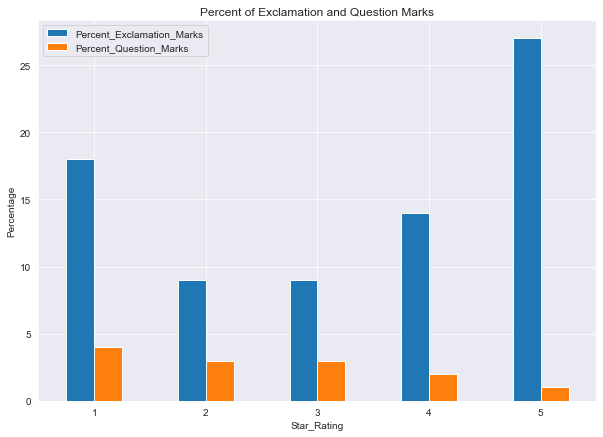

In [26]:
# Plot bar chart comparing exclamation and question marks by review star rating

allstar_e_q_count = {'Star_Rating':[1,2,3,4,5],
                     'Percent_Exclamation_Marks':[onestar_excla_count_val,twostar_excla_count_val,
                                               threestar_excla_count_val,fourstar_excla_count_val,
                                               fivestar_excla_count_val],
                    'Percent_Question_Marks':[onestar_ques_count_val,twostar_ques_count_val,
                                           threestar_ques_count_val,fourstar_ques_count_val,
                                           fivestar_ques_count_val]}

allstar_excla_ques_count_df = pd.DataFrame(allstar_e_q_count)
allstar_excla_ques_count_df = allstar_excla_ques_count_df.set_index('Star_Rating')

#plt.figure(figsize=(10,10))
sns.set_style("dark")
allstar_excla_ques_count_df.plot.bar(title="Percent of Exclamation and Question Marks",
                                    figsize=(10,7), grid=True)
plt.ylabel("Percentage")
plt.xticks(rotation=0, horizontalalignment="center")
plt.show()

<b>Results:</b></br>
As observed from the graph above, One and Five Star reviews are have the largest percentage of Exclamation Marks. One Star reviews at 18% and Five Star reviews at 27%. This proves that reviewers are more expressive with dissatisfaction and satisfaction of their products.

With regards to Question Marks, we observe that reviewers with the lowest satisfaction (One Star) question the quality/design/support of their product the most. One Star reviews had 4% Question Marks which dropped to 1% for Five Star reviews.

In [27]:
# all reviews with 5 or less words
five_less_word_reviews_df = reviews_df[reviews_df['num_of_words'] <= 5]
five_less_word_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4597 entries, 2 to 19995
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             4597 non-null   int64 
 1   review_body             4597 non-null   object
 2   num_of_words            4597 non-null   int64 
 3   num_exclamations_marks  4597 non-null   int64 
 4   num_questions_marks     4597 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 215.5+ KB


In [28]:
# Number of reviews with 5 or less words per star rating
five_less_word_reviews_df.groupby(['star_rating']).count()

,review_body,num_of_words,num_exclamations_marks,num_questions_marks
star_rating,,,,
1,173,173,173,173
2,59,59,59,59
3,164,164,164,164
4,528,528,528,528
5,3673,3673,3673,3673


In [29]:
# all reviews with more than 5 words
mt_five_word_reviews_df = reviews_df[reviews_df['num_of_words'] > 5]
mt_five_word_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15403 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             15403 non-null  int64 
 1   review_body             15403 non-null  object
 2   num_of_words            15403 non-null  int64 
 3   num_exclamations_marks  15403 non-null  int64 
 4   num_questions_marks     15403 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 722.0+ KB


In [ ]:
# Stats for reviews with more than 5 words
print("Max number of words:", mt_five_word_reviews_df['num_of_words'].max())
print("Average number of words:", mt_five_word_reviews_df['num_of_words'].mean())
print("Median number of words:", mt_five_word_reviews_df['num_of_words'].median())

In [30]:
# More than 5 word reviews by Star Rating
grouped_review_df = mt_five_word_reviews_df.groupby(['star_rating']).count()
grouped_review_df.head()

,review_body,num_of_words,num_exclamations_marks,num_questions_marks
star_rating,,,,
1,1309,1309,1309,1309
2,758,758,758,758
3,1238,1238,1238,1238
4,2536,2536,2536,2536
5,9562,9562,9562,9562


In [31]:
# One star reviews with more than 5 words
#mt_five_word_reviews_df.tail()
mtfive_1star_reviews_df = mt_five_word_reviews_df[mt_five_word_reviews_df['star_rating'] == 1].reset_index(drop=True)
mtfive_1star_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             1309 non-null   int64 
 1   review_body             1309 non-null   object
 2   num_of_words            1309 non-null   int64 
 3   num_exclamations_marks  1309 non-null   int64 
 4   num_questions_marks     1309 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 51.3+ KB


In [32]:
# Two star reviews with more than 5 words
mtfive_2star_reviews_df = mt_five_word_reviews_df[mt_five_word_reviews_df['star_rating'] ==2].reset_index(drop=True)
mtfive_2star_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   star_rating             758 non-null    int64 
 1   review_body             758 non-null    object
 2   num_of_words            758 non-null    int64 
 3   num_exclamations_marks  758 non-null    int64 
 4   num_questions_marks     758 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 29.7+ KB


In [ ]:
#mtfive_1star_reviews_df.head()

# Working with One Star Reviews

In [33]:
onestar_stopwords = {"the","i","a","and","to","of","this","for","in","that","on","my",
                     "you","they","have","so","as","are","at","be","product","is",
                    "had","would","if","all","get","them","these","from","its","when","or",
                     "me","will","back","an","sound","were","do","what","guitar","time",
                    "did","money","about","your","two","we","first","could","was",
                    "because","tried","return","there","which","made","any","now","am","then",
                    "by","thing","also","receive","im","way","their","item","way","before",
                     "after","power","into","came","put","piece","been","something",
                    "both","month","through","unit","ive","thi","aa",
                    "string","set","play","another","see","think","want","how","reviews",
                    "years","using","still","should","day","said","where","review","week",
                    "go","going","hold","try","went","every","it","etc"}
print(len(onestar_stopwords))

112


<b>Creating one star stopwords set</b>

In [34]:
# extracting docs and cleaning up for onestar reviews
onestar_docs_list = []

onestar_docs_list = cleanup_docs(mtfive_1star_reviews_df['review_body'])
#print(onestar_docs_list[:5])

In [35]:
#onestar_docs_list[1010:1020]

In [37]:
# Lemmatize one star docs
onestar_docs_list = lemmatize_tokens(onestar_docs_list)
#print(onestar_docs_list[1010:1020])

In [38]:
# extracting words/tokens from one star docs
onestar_word_list = []
for doc in onestar_docs_list:
    onestar_word_list.extend(doc.split())
    
print(len(onestar_word_list))

64105


In [39]:
print(mtfive_1star_reviews_df['num_of_words'].sum())
print(len(onestar_word_list))

64832
64105


In [40]:
# remove Domain Stop words
onestar_word_list = rm_stopwords(onestar_word_list, domain_stopwords)
print(len(onestar_word_list))

63488


In [41]:
# remove OneStar Stop words
onestar_word_list = rm_stopwords(onestar_word_list, onestar_stopwords)
print(len(onestar_word_list))

32951


In [42]:
# set of unique OneStar tokens
onestar_uniq_words = {}
onestar_uniq_words = get_uniq_words(onestar_word_list)
#print(onestar_uniq_words)
print(len(onestar_uniq_words))

5220


In [43]:
# sorting dictionary by values in descending order
onestar_uniq_sorted = sorted(onestar_uniq_words.items(), key=lambda x: x[1], reverse=True)


In [44]:
# printing first 200 items in dictionary
print(onestar_uniq_sorted[:10])

[('not', 895), ('with', 528), ('but', 486), ('one', 378), ('out', 295), ('work', 265), ('no', 245), ('very', 234), ('up', 223), ('just', 220)]


<b>----------- Testing TF-IDF --------------</b>

In [45]:
all_onestar_stopwords = {}
all_onestar_stopwords = domain_stopwords.union(onestar_stopwords)

In [ ]:
print(len(all_onestar_stopwords))

In [ ]:
#print(len(onestar_docs_list))

In [ ]:
#print(onestar_docs[1010:1020])

In [46]:
onestar_tfidf_df = create_tfidf_matrix(onestar_docs_list, all_onestar_stopwords)

In [47]:
onestar_tfidf_df.head()

,ability,able,abominable,above,absent,absolute,absolutely,absurd,abysmal,ac,...,yuk,zap,zelda,zero,zildjian,zip,zipper,zippered,zippers,zoom
0,0.0,0.178969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
onestar_hi_freq_dict = {}
onestar_hi_freq_dict = onestar_tfidf_df.sum().sort_values(ascending=False)[:50].to_dict()

In [61]:
print(onestar_hi_freq_dict)

{'not': 68.37688226614239, 'with': 39.03778895215983, 'work': 38.02605385612236, 'but': 36.70076986914715, 'one': 33.45218187563512, 'very': 26.741449886677035, 'out': 26.596267735736532, 'no': 24.40321118391035, 'dont': 22.454358180078103, 'broke': 22.03663200021299, 'even': 21.72911660329565, 'just': 21.27408975771867, 'didnt': 20.820447181876098, 'only': 20.74338669958656, 'use': 20.457937110071814, 'good': 19.9938014087165, 'quality': 19.813045003718578, 'up': 19.50995126960794, 'does': 18.699246937047086, 'waste': 17.42141225399954, 'like': 17.194548224090497, 'cheap': 16.57299186262444, 'fit': 16.179585709786704, 'doesnt': 16.123848209140103, 'got': 15.383051919934102, 'too': 15.159284537538237, 'mic': 15.084085535403634, 'received': 14.300338434505207, 'off': 14.292334260862807, 'never': 13.810392744019477, 'broken': 13.21228192946481, 'has': 13.207210976162107, 'worked': 13.196228261944363, 'really': 13.000192490581254, 'great': 12.947246805312647, 'bad': 12.75063473495695, 'mi

# -------- Word Cloud -------------

In [79]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=6000,height=4000, relative_scaling=1, background_color='white').generate_from_frequencies(onestar_hi_freq_dict)

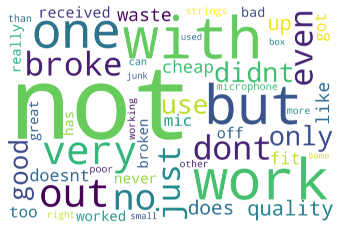

In [80]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
ten_words_df = reviews_df[reviews_df['num_of_words'] <= 10]
ten_words_df.info()

In [ ]:
large_words_df = reviews_df[reviews_df['num_of_words'] >= 2000]
large_words_df.info()

# --------- Test area below ---------

In [ ]:
print(count_words("This is not such a long sentence ya ?"))

In [ ]:
print(reviews_df.iloc[19912])
print(reviews_df.loc[19912, 'review_body'])

In [ ]:
## testing re functionality 
words = re.findall(['], "This isn't a crazy 22 test string . What exactly is it?")
print(words)
print(len(words))

In [ ]:
ques="?"
excla="!"
test_str = "Wow! that! is totally awesome!! No?"
print(test_str.count("?"))
print(test_str.count("!"))

In [ ]:
test_a = "This is a small review. Yes ^$ or no? I don't really know. Amazon !!"
#print(remove_special_chars(test_a))
print(mt_five_word_reviews_df.iloc[100]['review_body'])
print(remove_special_chars(mt_five_word_reviews_df.iloc[100]['review_body']))

In [ ]:
# removes special characters and some "<br />" and returns list of words
def remove_special_chars(data):
    word_list = []
    cleaned_list = []
    alphanum = ""
    data = data.replace("<br />"," ") #replace <br /> text in some reviews with space
    word_list = data.lower().split()
    
    for word in word_list:
        alphanum = [character for character in word if character.isalnum()]
        alphanum = "".join(alphanum)
        cleaned_list.append(alphanum)
        
    cleaned_list = list(filter(None, cleaned_list)) #remove Null values
    
    return cleaned_list

In [ ]:
# create tokens for onestar reviews
onestar_word_list = []

for index, row in mtfive_1star_reviews_df.iterrows():
        onestar_word_list.extend(remove_special_chars(mtfive_1star_reviews_df.iloc[index]['review_body']))
            
print(onestar_word_list[:20])

In [ ]:
list_words = []
print(mt_five_word_reviews_df.iloc[10777]['review_body'])
list_words = remove_special_chars(mt_five_word_reviews_df.iloc[10777]['review_body'])
#list_words = mt_five_word_reviews_df.iloc[10777]['review_body']
print("\n\n")
#list_words = list_words.replace("<br />"," ")
#print(list_words)

print(get_uniq_words(list_words))

In [ ]:
# filtering only reviews with exclamation or question marks
onestar_filtered_df = onestar_reviews_df.drop(onestar_reviews_df[(onestar_reviews_df['num_exclamations_marks'] == 0) & (onestar_reviews_df['num_questions_marks'] == 0)].index)
onestar_filtered_df.head()

In [ ]:
onestar_exclam_count = onestar_filtered_df[onestar_filtered_df['num_exclamations_marks'] != 0].count()
print(onestar_exclam_count['num_exclamations_marks'])

In [ ]:
onestar_ques_count = onestar_filtered_df[onestar_filtered_df['num_questions_marks'] != 0].count()
print(onestar_ques_count['num_questions_marks'])

In [ ]:
onestar_filtered_df.tail(30)

In [ ]:
domain_stopwords ={"amazon","bought","purchase","purchased","ordered","buy","facebook",
                   "google"}

In [ ]:
onestar_stopwords = {"the","i","a","and","to","of","this","for","is","was",
                    "in","that","on","my","you","they","have","so","as","are","at","be",
                    "had","would","if","all","get","them","these","from","its","when","or",
                     "me","will","back","an","sound","were","do","what","guitar","time",
                    "did","money","about","your","two","we","first","could",
                    "because","tried","return","there","which","made","any","now","am","then",
                    "by","thing","also","received","im","way","their","item","way","before",
                     "after","power","into","came","put","3","piece","been","something",
                    "both","months","through","unit","ive",
                    "string","set","play","another","see","think","want","how","reviews",
                    "years","using","still","should","day","said","where","review","week",
                    "go","going","hold","try","went","every","it","etc"}
print(len(onestar_stopwords))

In [ ]:
test_list = ["amazon","buy","bought","orange","purchased","guitar","pick","apple","amazons",
             "buys","purchase","string","strings","wouldnt","hightension","flies","is",
             "was","go","going","the","an"]


In [ ]:
# lemmatizing OneStar Tokens
onestar_word_list = lemmatize_tokens(onestar_word_list)
print(len(onestar_word_list))

In [ ]:
new_test_list = test_list.copy()

new_test_list.append('more')

print("Test List =", test_list,"\n")
print("new test list =", new_test_list)


In [ ]:
# testing WordNet Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

for word in test_list:
    print("Lemma for {} is {}".format(word, wordnet_lemmatizer.lemmatize(word)))

#print(test_list)

In [ ]:
# testing Porter Stemmer
from nltk.stem.porter import PorterStemmer
porter_stemmer  = PorterStemmer()

for word in test_list:
    print("Stemm for {} is {}".format(word, porter_stemmer.stem(word)))

In [ ]:
# testing pattern
import pattern 
from pattern.en import lemma, lexeme 
from pattern.en import parse 
  
sentence = "the bats saw the cats with best stripes hanging upside down by their feet"
  
#lemmatized_sentence = " ".join([lemma(word) for word in sentence.split()]) 

for word in test_list:
    print("Pattern for {} is {}".format(word, lemma(word)))
#print(lemmatized_sentence) 

In [ ]:
# testing Gensim
from gensim.utils import lemmatize 
  
for word in test_list:
    lemm_word = str(lemmatize(word))
    #print(type(lemm_word))
    lemm_word = lemm_word.split('/')[0]
    print("Gensim for {} is {}".format(word, lemm_word))
    
#lemmatized_out = [wd.decode('utf-8').split('/')[0] for wd in lemmatize(sentence)]


In [ ]:
import pattern 
from pattern.en import lemma
#from pattern.en import parse

lemms_list = []
for word in lemm_onestar_word_list:
    lemms_list.append(lemma(word))

print(lemms_list[:20])
print(len(lemms_list))

In [ ]:
def lemmatize_tokens(data):
    lemm_list = []
    for word in data:
        lemm_list.append(lemma(word))

    return lemm_list

In [ ]:
print(lemmatize_tokens(test_list))

In [ ]:
# creating copy onestar_word_list to test Lemmatization
lemm_onestar_word_list = []
lemm_onestar_word_list = onestar_word_list.copy()
print(lemm_onestar_word_list[:20])
print(len(lemm_onestar_word_list))

In [ ]:
print(lemms_list[64300:])

In [ ]:
lemm_uniq_words = {}
lemm_uniq_words = get_uniq_words(lemms_list)
print(len(lemm_uniq_words))

In [ ]:
lemm_uniq_sorted = sorted(lemm_uniq_words.items(), key=lambda x: x[1], reverse=True)

In [ ]:
print(lemm_uniq_sorted[:30])

In [ ]:
# remove Domain & OneStar Stop words
lemms_list = rm_stopwords(lemms_list, domain_stopwords)
print(len(lemms_list))
lemms_list = rm_stopwords(lemms_list, onestar_stopwords)
print(len(lemms_list))

In [ ]:
# removes special characters are some "<br />" and returns list of words
test_str2 = "Really bad. Bought as a midi trigger kit but the latency from the module is ridiculous. Comlete waste of $$. A toy. \
            x1234 instruments shaped adjustments DO NOT BUY it is gone and going"
  
lemma_test_str2 = lemma(test_str2)
print(lemma_test_str2)
print(lemma_test_str2.split())

In [ ]:
from gensim.utils import lemmatize
lemmatized_out = [lemmatize(test_str2)]

In [ ]:
print(lemmatized_out)

In [ ]:
import spacy

# create a spaCy tokenizer
spacy.load('en')
sp_lemmatizer = spacy.lang.en.English()



In [ ]:
sp_lemmatizer(test_str2)

In [ ]:
print(lemmatize_tokens(onestar_docs[1010:1020]))

In [ ]:
doc_a =[]
doc_b =[]
doc_a.append(mtfive_1star_reviews_df.iloc[2]['review_body'])
doc_b.append(mtfive_1star_reviews_df.iloc[4]['review_body'])
print(type(doc_a), ",", doc_a)
print(type(doc_b), ",", doc_b)

In [ ]:
doc_c =[]
doc_c = doc_a + doc_b
print(doc_c)

In [ ]:
# combining all more that 5 word onestar reviews into one list
onestar_docs = []
for index, row in mtfive_1star_reviews_df.iterrows():
    onestar_docs.append(mtfive_1star_reviews_df.iloc[index]['review_body'])

onestar_docs = cleanup_docs(onestar_docs)

In [ ]:
# removes special characters are some "<br />" and returns list of words
test_str = "Really bad. Bought as a midi trigger kit but the httpwwwababacom latency from the module is ridiculous. Comlete waste of $$. A toy. \
            x1234 34instrumentshaped 34adjustments34 httpswwwfacebookcommediasetseta17358580600471341625147817861914841 \
            have34stereo <br />DO NOT BUY"


In [ ]:
import re

test_str2 = test_str.lower()
#test_str2 = re.sub("","",test_str2)
test_str2 = re.sub('<br',' ',test_str2)
test_str2 = re.sub('http\S+',' ',test_str2)
test_str2 = re.sub('[^A-Za-z]+', ' ', test_str2)


In [ ]:
# Implementing TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
 
tfidf_vectorizer=TfidfVectorizer(use_idf=True, analyzer='word', stop_words=all_onestar_stopwords)

tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(onestar_docs_list)

In [ ]:
#print(tfidf_vectorizer.get_feature_names())

In [ ]:
# pulling the vocabulary from TFIDF and trying sort
type(tfidf_vectorizer.vocabulary_)
tfidf_vocab_dict = tfidf_vectorizer.vocabulary_
tfidf_vocab_sorted = sorted(tfidf_vocab_dict.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# creating the TFIDF matrix
token_names = tfidf_vectorizer.get_feature_names()
dense = tfidf_vectorizer_vectors.todense()
denselist = dense.tolist()
tfidf_df = pd.DataFrame(denselist, columns=token_names)

In [ ]:
tfidf_df.head()

In [ ]:
# adding up token frequency, then sorting in descending order and pick top X values
tfidf_df.sum().sort_values(ascending=False)[:10]